# Portfolio Optimization - a small exploration

**Goal.** I wanted to see whether a simple "maximize Sharpe" portfolio optimizer can produce a *repeatable* edge out-of-sample.

This notebook is written like a mini lab report: setup -> method -> results -> diagnostics -> conclusion.


## Abstract

I tested a basic mean-variance style workflow: estimate daily returns and a covariance matrix on a **train** window, optimize long-only weights to maximize in-sample Sharpe, then evaluate the resulting fixed weights on a **test** window.

The punchline: the optimizer can look great *in-sample*, but performance degrades materially out-of-sample. The diagnostics (mean shifts + correlation shifts) suggest the apparent edge is largely an artifact of estimation noise / regime dependence rather than a stable signal. For this toy setup, the most honest conclusion is that the exercise is mainly a lesson in **overfitting**.


## 1) Setup

A few notes on choices:
- **Long-only + weight caps** to prevent the optimizer from doing extreme allocations.
- Use **daily returns** and annualize with 252 trading days.
- Compare two implementations:
  - **RB (daily rebalanced)**: portfolio is rebalanced back to target weights each day.
  - **BH (buy-and-hold)**: weights drift naturally after the initial allocation.

No transaction costs are included (that would only make the optimistic results look worse).


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
pd.set_option("display.float_format", lambda x: f"{x:0.6f}")
ANN = 252 


## 2) Data

I'll use a small, diversified ETF basket (US equities, treasuries, credit, gold, REITs, developed ex-US, emerging markets).

Feel free to swap tickers - the point of the notebook is the *process*, not the exact list.


In [6]:
tickers = ["SPY", "IEF", "LQD", "TLT", "GLD", "VNQ", "VEA", "VWO"]
start = "2018-01-01"
end   = "2024-01-01"
split_date = "2022-01-01"
w_min = 0.0
w_max = 0.35


In [10]:
px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
px = px.dropna(how="any")
rets = px.pct_change().dropna()
split_date = pd.Timestamp(split_date)
px_train = px.loc[:split_date].copy()
px_test  = px.loc[split_date:].copy()
rets_train = px_train.pct_change().dropna()
rets_test  = px_test.pct_change().dropna()

## 3) Helper functions (metrics + portfolio returns)

Keeping these small and readable on purpose.


In [11]:
def _to_1d(x):
    if isinstance(x, pd.DataFrame):
        if x.shape[1] != 1:
            raise ValueError(f"Expected 1 column, got {x.shape[1]}")
        x = x.iloc[:, 0]
    if isinstance(x, pd.Series):
        x = x.values
    x = np.asarray(x)
    return np.ravel(x)

def ann_return(daily_ret):
    r = pd.Series(_to_1d(daily_ret)).dropna()
    return (1 + r).prod() ** (ANN / len(r)) - 1

def ann_vol(daily_ret):
    r = pd.Series(_to_1d(daily_ret)).dropna()
    return r.std() * np.sqrt(ANN)

def sharpe(daily_ret, rf=0.0):
    r = pd.Series(_to_1d(daily_ret)).dropna()
    if r.std() == 0:
        return np.nan
    return (r.mean() * ANN - rf) / (r.std() * np.sqrt(ANN))

def max_drawdown(equity_curve):
    x = pd.Series(_to_1d(equity_curve)).dropna()
    peak = x.cummax()
    dd = x / peak - 1.0
    return dd.min()

def perf_table(daily_ret, name):
    r = pd.Series(_to_1d(daily_ret)).dropna()
    out = pd.DataFrame({
        name: [ann_return(r), ann_vol(r), sharpe(r), max_drawdown((1+r).cumprod())]
    }, index=["Ann Return", "Ann Vol", "Sharpe", "Max Drawdown"])
    return out

def portfolio_rebalanced(rets_df, w):
    w = _to_1d(w)
    if rets_df.shape[1] != len(w):
        raise ValueError(f"rets_df has {rets_df.shape[1]} cols but weights have len {len(w)}")
    return rets_df.values @ w

def portfolio_buyhold(px_df, w):
    w = _to_1d(w)
    w = w / w.sum()
    # normalize prices to 1 at start
    norm = px_df / px_df.iloc[0]
    equity = (norm.values * w).sum(axis=1)
    # convert to daily returns too (for metrics)
    daily_ret = pd.Series(equity, index=px_df.index).pct_change().dropna()
    return pd.Series(equity, index=px_df.index), daily_ret


## 4) Baselines and per-asset stats

Before optimizing anything, I like to look at:
- annualized return / vol per asset (train vs test),
- and the plain benchmark performance (SPY here is already in the universe, but we also report it explicitly).


In [12]:
def asset_stats(rets_df):
    mu = rets_df.mean() * ANN
    vol = rets_df.std() * np.sqrt(ANN)
    sh = mu / vol
    return pd.DataFrame({"Ann. Return": mu, "Ann. Vol": vol, "Sharpe (asset)": sh})

stats_train = asset_stats(rets_train)
stats_test  = asset_stats(rets_test)

display(stats_train.sort_values("Sharpe (asset)", ascending=False))
display(stats_test.sort_values("Sharpe (asset)", ascending=False))

# mean shift table
mu_shift = pd.DataFrame({
    "mu_train": stats_train["Ann. Return"],
    "mu_test":  stats_test["Ann. Return"],
})
mu_shift["diff (test-train)"] = mu_shift["mu_test"] - mu_shift["mu_train"]
display(mu_shift.sort_values("diff (test-train)"))


,Ann. Return,Ann. Vol,Sharpe (asset)
Ticker,,,
SPY,0.181676,0.208138,0.872866
IEF,0.039570,0.055757,0.709684
VNQ,0.152709,0.244202,0.625339
GLD,0.088055,0.141227,0.623495
LQD,0.058074,0.095950,0.605255
TLT,0.072703,0.148780,0.488657
VEA,0.078712,0.193472,0.406841
VWO,0.066228,0.221425,0.299097


,Ann. Return,Ann. Vol,Sharpe (asset)
Ticker,,,
GLD,0.074369,0.143318,0.518911
SPY,0.032217,0.195273,0.164982
VEA,0.013220,0.185195,0.071387
VWO,-0.041085,0.188891,-0.217504
VNQ,-0.067574,0.226065,-0.298912
LQD,-0.042745,0.110575,-0.386571
IEF,-0.055274,0.098089,-0.563510
TLT,-0.142800,0.193704,-0.737204


,mu_train,mu_test,diff (test-train)
Ticker,,,
VNQ,0.152709,-0.067574,-0.220283
TLT,0.072703,-0.142800,-0.215502
SPY,0.181676,0.032217,-0.149460
VWO,0.066228,-0.041085,-0.107312
LQD,0.058074,-0.042745,-0.100819
IEF,0.039570,-0.055274,-0.094844
VEA,0.078712,0.013220,-0.065492
GLD,0.088055,0.074369,-0.013685


## 5) Optimize weights on the train window

We maximize **in-sample Sharpe** subject to:
- sum(w) = 1
- w_min ≤ wᵢ ≤ w_max

Important: this is *exactly* the kind of thing that tends to overfit when you use sample means.


In [13]:
def neg_sharpe_obj(w, rets_df):
    p = portfolio_rebalanced(rets_df, w)
    s = sharpe(p)
    return -s

n = rets_train.shape[1]
w0 = np.ones(n) / n
bounds = [(w_min, w_max)] * n
cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]

res = minimize(neg_sharpe_obj, w0, args=(rets_train,), method="SLSQP", bounds=bounds, constraints=cons)
w_opt = _to_1d(res.x)
w_opt = w_opt / w_opt.sum()

print("Success:", res.success, "|", res.message)
print("Sharpe (train, objective):", -res.fun)
print("w sum:", w_opt.sum(), "| min/max:", w_opt.min(), w_opt.max())
weights_tbl = pd.DataFrame({"ticker": rets_train.columns, "weight": w_opt}).sort_values("weight", ascending=False)
display(weights_tbl)


Success: True | Optimization terminated successfully
Sharpe (train, objective): 1.3552253208727094
w sum: 1.0 | min/max: 3.9736009621593738e-16 0.34999999999999815


,ticker,weight
1,IEF,0.350000
3,SPY,0.322257
4,TLT,0.214863
0,GLD,0.112880
6,VNQ,0.000000
7,VWO,0.000000
5,VEA,0.000000
2,LQD,0.000000


### Sanity check: random portfolios

Just a check that the optimizer isn't obviously broken.


In [14]:
rng = np.random.default_rng(0)

def random_weights(n, w_min=0.0, w_max=0.35, trials=5000):
    out = []
    for _ in range(trials):
        w = rng.random(n)
        w = w / w.sum()
        if (w >= w_min).all() and (w <= w_max).all():
            out.append(w)
    return np.array(out)

W = random_weights(n, w_min=w_min, w_max=w_max, trials=30000)
print("Random feasible portfolios:", len(W))

if len(W) > 0:
    sharpes = np.array([sharpe(portfolio_rebalanced(rets_train, w)) for w in W])
    print("Best random Sharpe (train):", sharpes.max())

    best_w = W[sharpes.argmax()]
    display(pd.DataFrame({"ticker": rets_train.columns, "weight": best_w}).sort_values("weight", ascending=False))


Random feasible portfolios: 29586
Best random Sharpe (train): 1.2511240089257836


,ticker,weight
4,TLT,0.244190
3,SPY,0.242939
1,IEF,0.234537
0,GLD,0.170200
2,LQD,0.047843
5,VEA,0.041766
6,VNQ,0.016950
7,VWO,0.001575


## 6) Backtest: train vs test (RB and BH)

Doing this to:
- train (in-sample),
- test (out-of-sample).

Again: no transaction costs.


In [15]:
port_train_rb = pd.Series(portfolio_rebalanced(rets_train, w_opt), index=rets_train.index)
port_test_rb  = pd.Series(portfolio_rebalanced(rets_test,  w_opt), index=rets_test.index)

eq_train_bh, port_train_bh = portfolio_buyhold(px_train, w_opt)
eq_test_bh,  port_test_bh  = portfolio_buyhold(px_test,  w_opt)

spy_train = rets_train["SPY"] if "SPY" in rets_train.columns else rets_train.iloc[:,0]
spy_test  = rets_test["SPY"]  if "SPY" in rets_test.columns  else rets_test.iloc[:,0]

train_tbl = pd.concat([perf_table(port_train_rb, "Portfolio RB (train)"),perf_table(spy_train,     "SPY (train)"),perf_table(port_train_bh, "Portfolio BH (train)"),], axis=1)

test_tbl = pd.concat([perf_table(port_test_rb, "Portfolio RB (test)"),perf_table(spy_test,     "SPY (test)"),perf_table(port_test_bh, "Portfolio BH (test)"),], axis=1)

display(train_tbl)
display(test_tbl)


,Portfolio RB (train),SPY (train),Portfolio BH (train)
Ann Return,0.100014,0.173314,0.096850
Ann Vol,0.072281,0.208138,0.071224
Sharpe,1.355225,0.872866,1.333827
Max Drawdown,-0.111871,-0.337173,-0.116165


,Portfolio RB (test),SPY (test),Portfolio BH (test)
Ann Return,-0.036652,0.013262,-0.038220
Ann Vol,0.110492,0.195273,0.107978
Sharpe,-0.282840,0.164982,-0.307043
Max Drawdown,-0.213563,-0.244711,-0.216188


### Equity curves

I plot growth of $1 to keep it intuitive.


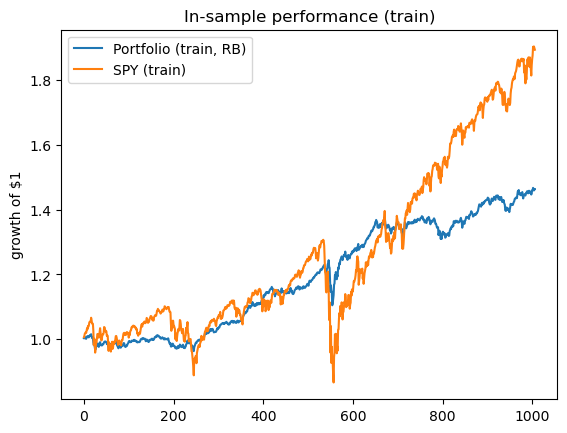

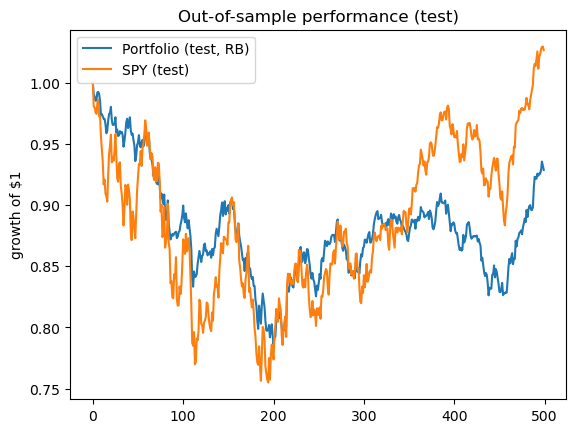

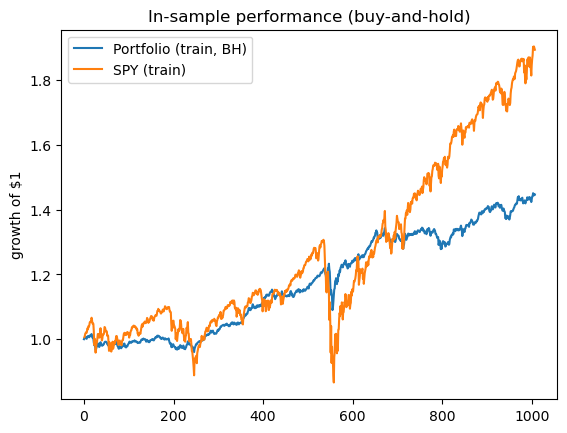

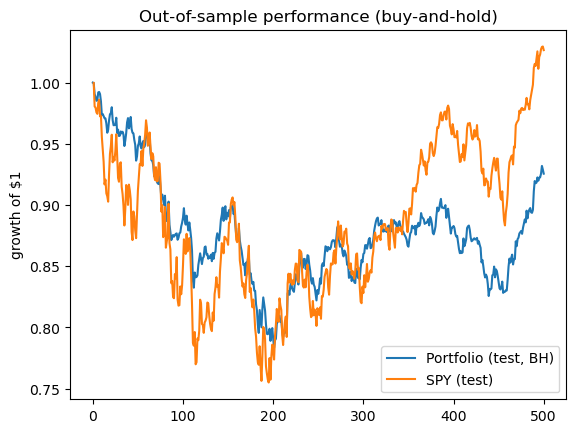

In [20]:
def growth_curve(daily_ret, index=None):
    if isinstance(daily_ret, (pd.Series, pd.DataFrame)):
        r = daily_ret.squeeze().copy()
    else:
        r = pd.Series(_to_1d(daily_ret), index=index)
    r = r.dropna()
    return (1 + r).cumprod()


plt.figure()
plt.plot(growth_curve(port_train_rb).values, label="Portfolio (train, RB)")
plt.plot(growth_curve(spy_train).values, label="SPY (train)")
plt.legend()
plt.title("In-sample performance (train)")
plt.ylabel("growth of $1")
plt.show()

plt.figure()
plt.plot(growth_curve(port_test_rb).values, label="Portfolio (test, RB)")
plt.plot(growth_curve(spy_test).values, label="SPY (test)")
plt.legend()
plt.title("Out-of-sample performance (test)")
plt.ylabel("growth of $1")
plt.show()

plt.figure()
plt.plot(eq_train_bh.values, label="Portfolio (train, BH)")
plt.plot(growth_curve(spy_train).reindex(eq_train_bh.index).values, label="SPY (train)")
plt.legend()
plt.title("In-sample performance (buy-and-hold)")
plt.ylabel("growth of $1")
plt.show()

plt.figure()
plt.plot(eq_test_bh.values, label="Portfolio (test, BH)")
plt.plot(growth_curve(spy_test).reindex(eq_test_bh.index).values, label="SPY (test)")
plt.legend()
plt.title("Out-of-sample performance (buy-and-hold)")
plt.ylabel("growth of $1")
plt.show()


## 7) Diagnostics: why did test performance drift?

Two quick checks that usually explain a lot in these toy optimizers:

1. **Mean instability:** sample means are noisy, and small mean changes dominate Sharpe optimization.
2. **Correlation / covariance shifts:** diversification assumptions from the train window may not hold later.


In [22]:
corr_train = rets_train.corr()
corr_test  = rets_test.corr()
corr_train.index.name  = "asset_i"
corr_train.columns.name = "asset_j"
corr_test.index.name   = "asset_i"
corr_test.columns.name  = "asset_j"
corr_delta = corr_test.sub(corr_train)
corr_change = (corr_delta.stack().rename("corr_change").reset_index())
corr_change = corr_change[corr_change["asset_i"] != corr_change["asset_j"]]
corr_change["abs_corr_change"] = corr_change["corr_change"].abs()

display(corr_train)
display(corr_test)
display(corr_change.sort_values("abs_corr_change", ascending=False).head(15))


asset_j,GLD,IEF,LQD,SPY,TLT,VEA,VNQ,VWO
asset_i,,,,,,,,
GLD,1.000000,0.314156,0.310945,0.077120,0.257954,0.154171,0.112412,0.160950
IEF,0.314156,1.000000,0.470387,-0.401174,0.927823,-0.383678,-0.226863,-0.322238
LQD,0.310945,0.470387,1.000000,0.267914,0.464162,0.285251,0.339350,0.250552
SPY,0.077120,-0.401174,0.267914,1.000000,-0.387562,0.901731,0.783595,0.799368
TLT,0.257954,0.927823,0.464162,-0.387562,1.000000,-0.373332,-0.246076,-0.303796
VEA,0.154171,-0.383678,0.285251,0.901731,-0.373332,1.000000,0.737855,0.861845
VNQ,0.112412,-0.226863,0.339350,0.783595,-0.246076,0.737855,1.000000,0.601670
VWO,0.160950,-0.322238,0.250552,0.799368,-0.303796,0.861845,0.601670,1.000000


asset_j,GLD,IEF,LQD,SPY,TLT,VEA,VNQ,VWO
asset_i,,,,,,,,
GLD,1.000000,0.496905,0.423101,0.132802,0.369500,0.294313,0.198215,0.268636
IEF,0.496905,1.000000,0.883508,0.142826,0.912012,0.180669,0.301367,0.114718
LQD,0.423101,0.883508,1.000000,0.421630,0.868961,0.434935,0.493969,0.333180
SPY,0.132802,0.142826,0.421630,1.000000,0.101685,0.848263,0.773961,0.687570
TLT,0.369500,0.912012,0.868961,0.101685,1.000000,0.132702,0.265622,0.091266
VEA,0.294313,0.180669,0.434935,0.848263,0.132702,1.000000,0.707271,0.814375
VNQ,0.198215,0.301367,0.493969,0.773961,0.265622,0.707271,1.000000,0.543897
VWO,0.268636,0.114718,0.333180,0.687570,0.091266,0.814375,0.543897,1.000000


,asset_i,asset_j,corr_change,abs_corr_change
13,IEF,VEA,0.564347,0.564347
41,VEA,IEF,0.564347,0.564347
25,SPY,IEF,0.544000,0.544000
11,IEF,SPY,0.544000,0.544000
49,VNQ,IEF,0.528230,0.528230
14,IEF,VNQ,0.528230,0.528230
38,TLT,VNQ,0.511698,0.511698
52,VNQ,TLT,0.511698,0.511698
44,VEA,TLT,0.506034,0.506034
37,TLT,VEA,0.506034,0.506034


### Turnover (RB only)

Daily rebalancing implies trading. Even if turnover looks small, adding costs will reduce any marginal edge.


In [18]:
def turnover_daily(rets_df, w):
    w = _to_1d(w)
    w = w / w.sum()
    w_t = w.copy()
    tos = []
    for r in rets_df.values:
        w_next = w_t * (1 + r)
        tos.append(np.sum(np.abs(w - w_next)) / 2.0)
        w_t = w  
    return np.array(tos)

to_train = turnover_daily(rets_train, w_opt)
print("Turnover (train, daily rebalance): mean=%0.4f, median=%0.4f, p95=%0.4f" % (
    np.mean(to_train), np.median(to_train), np.quantile(to_train, 0.95)
))


Turnover (train, daily rebalance): mean=0.0028, median=0.0022, p95=0.0065


### Return contributions (train vs test)

This is a quick way to see whether the portfolio was leaning on a specific asset that stopped behaving similarly.


In [ ]:
contrib_train = (rets_train.mean() * w_opt).rename("mean_contrib_train")
contrib_test  = (rets_test.mean()  * w_opt).rename("mean_contrib_test")

contrib = pd.concat([contrib_train, contrib_test], axis=1)
contrib["abs_gap"] = (contrib["mean_contrib_test"] - contrib["mean_contrib_train"]).abs()
display(contrib.sort_values("abs_gap", ascending=False))


,mean_contrib_train,mean_contrib_test,abs_gap
Ticker,,,
SPY,0.000232,0.000041,0.000191
TLT,0.000062,-0.000122,0.000184
IEF,0.000055,-0.000077,0.000132
GLD,0.000039,0.000033,0.000006
VNQ,0.000000,-0.000000,0.000000
VWO,0.000000,-0.000000,0.000000
LQD,0.000000,-0.000000,0.000000
VEA,0.000000,0.000000,0.000000


## 8) Conclusion

**What I think happened:**
- The optimizer is extremely sensitive to **sample mean returns**.
- Train (2018–2021) and test (2022–2023) behave differently for several assets (returns and correlations shift).
- So the optimizer essentially "learns" the quirks of the train window and fails to generalize.

**Takeaway.** 
- For this setup, there is no convincing evidence of a stable edge. The right lesson is not keep tuning; it’s this is how easy it is to overfit.

**If I were to continue:**
- Walk-forward / rolling windows (re-estimate weights periodically).
- Use shrinkage / robust estimates (especially for means).
- Add simple transaction costs and compare net performance.
- Stress test with multiple universes (different baskets, not just one hand-picked set).

But as an exploratory personal project, I think I'll stop here
